<a href="https://colab.research.google.com/github/ddovidovich/DataScienceLerning/blob/main/UNIT_20_DZ_Ultra_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом задании, требуется обучить алгоритм REINFORCE на среде `health_gathering.cfg` из библиотеки ViZDoom. Желательно (но не обязательно) добиться стабильного успеха в обучении алгоритма.

#Среда "Health Gathering"

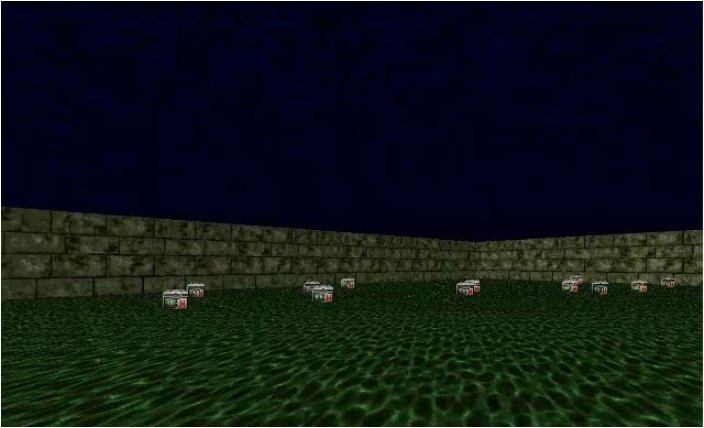

Суть и правила игры заключаются в следующем:

* Агент (игрок) находиться в комнате с кислотой, и постоянно теряет здоровие. Текущее здоровие агента можно найти через команду `game_data.game_variables`.

* Чтобы жить, агент должен собирать мед-пакеты, которые переодический появляются в комнате.

* Среда `health_gathering` будет рассматриваться на отдельном курсе по обучению с подкреплением. Там будем рассматривать значительно более мощний алгоритм, чем REINFORCE - однако текущее задание нужно выполнить именно с алгоритмом REINFORCE.



Для того, чтобы запустить среду ViZDoom в колаб-ноутбуке, нам нужно сначала установить различные дополнительные программы которые упомянаются в официальной документации.

In [ ]:
%%bash
#%%bash - значит используем командную строку (не код питона)
# Устанавливаем нужные программы, которая требует от нас документация: https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get update

apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Устанавливаем библиотеку Boost
apt-get install libboost-all-dev

# Устанавливаем зависимости Lua
apt-get install liblua5.1-dev

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease [24.3 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,169 kB]
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,343 kB]
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Pa

In [ ]:
!pip install imageio==2.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.6 MB/s eta 0:00:00
  Attempting uninstall: imageio
    Found existing installation: imageio 2.25.1
    Uninstalling imageio-2.25.1:
      Successfully uninstalled imageio-2.25.1


Затем, устанавливаем саму библиотеку ViZDoom из её гитхаб репозитории.

In [ ]:
#Обычно уходит 5-10 минут на установку этой библиотеки.
!pip install vizdoom==1.1.11

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 40.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for vizdoom: filename=vizdoom-1.1.11-cp310-cp310-linux_x86_64.whl size=14270606 sha256=f305cc2e7d1fd80e703b4fcc783046798f48eff84841ce08017ef46c6ee3a756
  Stored in directory: /root/.cache/pip/wheels/5a/11/d4/c2f007b24f357b7a5a3390efd04cd7d197340160994ca378d6
Successfully built vizdoom


In [ ]:
import gdown #Импортируем модуль для скачивания датасетов

#Скачиваем файлы для ViZDoom
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l6/rl.zip', output = None, quiet = True)
!unzip -qo rl.zip -d /content/ViZDoom/ #Разархивируем файлы

Подключаемся к диску и импортируем все нужные модули и библиотеки.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from vizdoom import *         #Импортируем все функции из cреды ViZDoom
import tensorflow as tf       #Библиотека тензорфлоу
import numpy as np            #Библиотека numpy
import random                 #Импортируем модуль для генерации рандомных значений
import pickle                 #Модуль для сохранения результатов в файл
import cv2                    #Модуль для работы с картинками и видео (нужно для предобработки данных и записи результата)

#Импортируем тип данных deque из встроенного модуля питона
from collections import deque   #deque - это список где автоматический удаляются старые значения при добовлении новых, чтобы не было переполнение памяти.
import matplotlib.pyplot as plt #Импортируем модуль pyplot из бибиотеки matplotlib

from tensorflow.keras.models import load_model, Model, Sequential #Импортируем функции для создания и загрузки модели из тензорфлоу
from tensorflow.keras.layers import *                             #Импортируем все слои из кераса
from tensorflow.keras.optimizers import RMSprop                   #Импортируем оптимизатор RMSprop
from tensorflow.keras import backend as K                         #Импортируем модуль для бэкэнда кераса
from tensorflow.keras.utils import to_categorical                 #Импортируем функцию для удобного onehot энкодинга
from moviepy.editor import *                                      #Импортируем полезные функции из библиотеки для возпроизведение видео с результатом
from google.colab import output                                   #Импортируем функцию для управления вывода в колаб-ячейках

Сначала, мы создадим среду чтобы понять, сколько у нас возможных действий.

(у агента есть три возможных действий - поворот на право, поворот на лево, шаг вперёд).

In [ ]:
game = vizdoom.DoomGame() #Инициализируем среду.
game.load_config("/content/ViZDoom/scenarios/health_gathering.cfg") #Загружаем сценарий "сбор здоровия"
game.set_screen_resolution(ScreenResolution.RES_320X240) #Устанавливаем размер кадров среды (будет 320 х 240)
game.set_window_visible(False) #Нужно отключить окно чтобы не было ошибки
game.init() #Инициализируем игру

action_size = game.get_available_buttons_size()                 #Извлекаем количество возможных уникальных действий

Сначала, мы задаем различные гиперпараметры, с которыми будем обучать алгоритм.

In [ ]:
image_width = 92          #Задаем желанный размер изображений (по горизонтали)
image_height = 92         #Задаем желанный размер изображений (по вертикали)
num_frames = 4            #Задаем количество кадров в одном состоянии
input_shape = (image_width, image_height, num_frames) #Задаем входную размерность нейронной сети

frames_per_action = 4     #Задаем количество кадров за каждое действие (сколько раз агент повторяет выбранное действие) - в этой среде не нужно реагировать быстро, а большое значение параметра усиливает сигнал награды, т.е. стабилизирует обучение.
gamma = 0.95              #Задаем значение гаммы для распростронении награды

Затем мы создаем и компилируем нейронную сеть.

In [ ]:
model = Sequential()
model.add(Conv2D(32, 8, strides = (4,4), input_shape=(input_shape))) #Сверточный слой
model.add(BatchNormalization())  #Нормализация пакета
model.add(Activation('elu'))  #Активационная функция
model.add(Conv2D(64, 4, strides = (2,2))) #Сверточный слой
model.add(BatchNormalization())  #Нормализация пакета
model.add(Activation('elu'))  #Активационная функция
model.add(Conv2D(128, 4, strides = (2,2))) #Сверточный слой
model.add(BatchNormalization())  #Нормализация пакета
model.add(Activation('elu'))  #Активационная функция
model.add(Flatten()) #Выходная размерность выравнивающего слоя - 256
model.add(Dense(512, activation = 'elu')) #Создаем пуллинговый полносвязанный слой с 512 нейронами
model.add(Dense(action_size, activation = 'softmax')) #Задаем выходной полносвязанный слой

#Компилируем модель
model.compile(optimizer = RMSprop(learning_rate = 2e-3), loss = 'sparse_categorical_crossentropy')

Зададим функцию, по которой алгоритм будет выбирать действие.

In [ ]:
#Функция для выбора действия принимает на вход состояние среды
def choose_action(state):      
  #Из предикта модели принимаем вероятности для действий И значение критика (значение критика нам не нужно, его принимаем только чтобы избежать ошибку)
  actor_probabilities = model.predict(np.expand_dims(state, axis = 0))      

  action_index = np.random.choice(action_size, p = actor_probabilities.flatten()) #Выбираем нужное действие  
  return action_index #Возвращаем индекс выбранного действия   

Дальше создадим функцию для предобработки наград.

Нужно отметить, что в этой задачи можно использовать функцию для предобработки непрерывных наград, или функцию для обработки скудных наград - и на то и на другое есть логика (но нужно поменять логику выдачи наград под эту функцию). В данном случае, мы используем функцию для обработки скудных наград.

Также нужно отметить, что в данной функции награды нормируются. В теоретической части, мы объясняли что так делать не желательно, потому что агент не сможет стабильно обучаться с наградами, которые приведены в нормальное расспределение. Это действительно так - как мы увидем позже, агент не сможет обучиться полностью стабильно и до конца (однако, эффект этого уменьшен, потому что мы будем обучать агента не на одном эпизоде а на несколько эпизодов одновременно). тем не менее, практика показывает что если мы НЕ будем нормировать награды, эти награды будут слишком скудные чтобы обучать агента.

In [ ]:
#Создадим функцию для предобработки наград
def preprocess_rewards(rewards):
  processed_rewards = np.zeros_like(rewards).astype(np.float32)  #Создаем массив из нулей, где будем хранить обработанные награды
  running_add = 0 #Параметр скользящий награды (инициализируется как 0)
  for i in reversed(range(0, len(rewards))): #В цикле прохохдим по массиву наград
    running_add = running_add * gamma + rewards[i] #Считаем новое значение скользящей награды
    processed_rewards[i] = running_add #Устанавливаем значение скользящей награды
  processed_rewards = (processed_rewards - np.mean(processed_rewards))/processed_rewards.std() #Нормируем обработанные награды
  return processed_rewards.tolist() #Возвращаем награды в виде списка

Создадим функцию, которая будет сжимать изображение в нужный размер (92 х 92) и превращать изображение в черно-белое.

In [ ]:
#Создаем функцию для предобработки кадра (сжимаем размер изобрадения до 92 х 92 и превращаем в черно-белый цвет).
def preprocess_frame(frame):
  frame = np.rollaxis(frame, 0, 3) #Сначала нужно предобрадотать картинку чтобы размер поменялся с (3, width, height) на (width, height, 3).
  frame = frame[40:, :, :]
  frame = cv2.resize(frame, (image_width, image_height), interpolation=cv2.INTER_CUBIC) #Меняем размерность картинки на (82 х 82)
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Делаем изображение чёрно-белым

  return frame.reshape(image_width, image_height, 1)/255 #Делаем решейп, и возврашаем предобработанную картинку, нормализуем

Создадим самописную функцию для назначения награды.

Логика этой функции заключается в следующем: 

Если агент теряет здоровье, награда не уменьшается т.к. здоровье всегда будет уменьшаться постепенно. 

Если агент приобритает здоровье, он получает положительную награду т.к. подразумивается что он взял аптечку, что как раз и нужно делать.

Если агент умирает, встроенная функция выдаст отрициательную награду. Ниже представленная функция используется совместно с встроенной функцией.



In [ ]:
#Функция назначении награды принимает на вход два параметра: предыдущую и текущую информацию об агенте
def get_reward(previous_info, current_info):
  return max(0, current_info[0] - previous_info[0])/10 #Возвращаем 0 если агент потерял или не приобрел здоровье, и положительную награду иначе

Создаем функцию для обучения нейронной сети.

In [ ]:
#Функция для обучения сети принимает на вход список состояний, действий, и наград за весь эпизод
def train(states, actions, rewards):
  #Сначала, переводим списки состояний и действий в numpy-массивы
  states, actions, rewards = np.array(states).astype(np.float32), np.array(actions).astype(np.float32), np.array(rewards).astype(np.float32)

  model.train_on_batch(states, actions, sample_weight = rewards) #Затем мы обучаем агента используя весь эпизод как один пакет

In [ ]:
#Создаем функцию для визуализации результата - здесь будем отслеживать только длительность эпизодов
def show_scores(scores):
  output.clear() #Удаляем предидущий вывод ячейки
  #Создаем два сабплота (в левом будут награды и средние награды, в правом будут количества убитых врагов и патронов) 
  plt.figure(figsize = (20, 8))                                               #Устанавливаем большой размер полотна
  plt.plot(scores, 'r--', label = "Длительность эпизодов")                        #Отрисовываем награды за весь эпизод
  plt.plot(moving_average(scores), 'k', label = "Длительность эпизодов (скользящее среднее)") #Отрисовываем скользящие средние награды
  plt.xlabel("Итерация", fontsize = 16)                              #Добавляем лейблы осей
  plt.ylabel("Награда", fontsize = 16)
  plt.legend()                               #Добавляем легенду к графику                               #
  plt.show()   #Отображаем график

#Также мы создадим функцию для подсчета скользящего среднего всех значений.
#Это будет осуществляться через матиматическую свёртку, и мы будем считать скользящее среднее за 10 значений.

def moving_average(data, width = 10): #data - входной массив, width - длина на которое считаем скользящее среднее.
  width = min(width, len(data))       #Длина свёртки (минимум из заданной длины свёртки и длины датасета)
  data = np.concatenate([np.repeat(data[0], width), data])         #Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива)
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  #Возвращаем результат свёртки данных на фильтр из единиц - наше скользящее среднее

Следующий блок кода решает если мы загружаем ранее сохраненные данные и веса модели чтобы продолжить обучение, или инициализируем списки для хранения данных и обучаем обучение с нуля.

In [ ]:
load_pretrained = False

if load_pretrained: #Если хотим продолжить обучение с ранее сохранненого момента:
  model.load_weights('/content/drive/My Drive/health_gathering_REINFORCE.h5')     #Загружаем веса основной модель из файла
  with open("/content/drive/My Drive/health_gathering_REINFORCE.txt", 'rb') as f:
    record_durations = pickle.load(f) #Загружаем список длительностей эпизодов из бинарного файла. В этот список добавился PER_B, который является параметром буфера памяти.
#Иначе мы просто инизиализируем списки, в которых будет храниться статистика о работе агента.
else:
  record_durations = [] #Сюда будем записывать длину каждого эпизода

Далее, создаем цикл игры и обучения агента.

Этот цикл отличается от игрового цикла с занятия Q-обучения. Все отличия возникают потому что алгоритм REINFORCE обучается на всём эпизоде одновременно.

Также, нужно отметить, что было принято решение обучаться не на одном эпизоде, а на нескольких эпизодов одновременно. То есть, агент играет в 5 эпизодов, и все данные с 5 эпизодов считаются как один пакет - затем модель обучается на одном пакете. Практика показала, что это помогает стабилизировать обучение. Однако, важно отметить, что при применении такого приема, награды нужно обрабатывать отдельно по всем эпизодам - иначе нейронная сеть подумает что текущий эпизод и награды в текущем эпизоде связанны с предыдущем эпизодом.

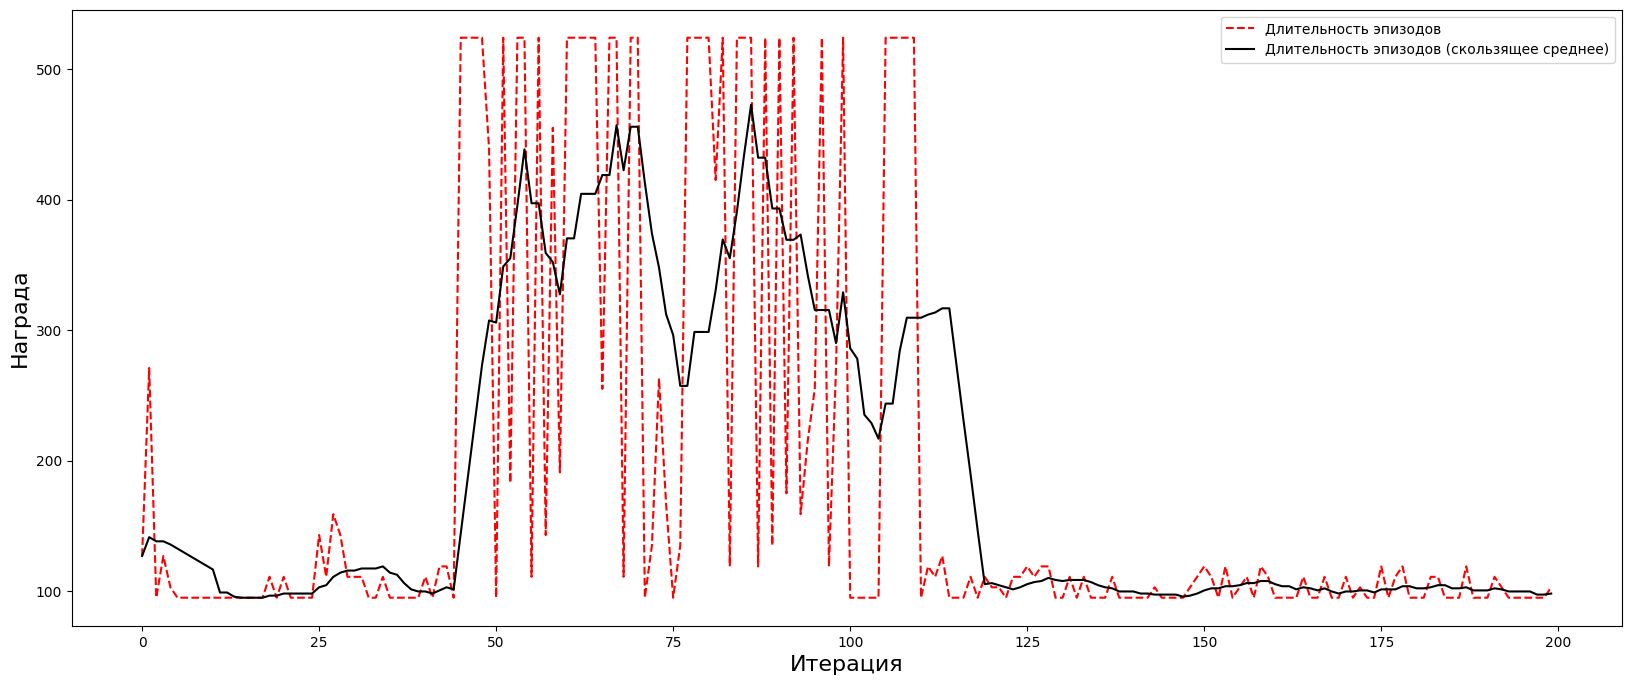

Статистика успешно сохранена.


In [ ]:
game.new_episode()                       #Начинаем новый эпизод игры
game_data = game.get_state()             #Извлекаем информацию о текущем состоянии игры
current_info = game_data.game_variables  #current_info - массив который содержит количество убитых врагов, наличие патронов, и здоровие на текущий момент
previous_info = current_info             #previous_info - массив который содержит количество убитых врагов, наличие патронов, и здоровие на предидущий момент

frame = game_data.screen_buffer                           #Извлекаем кадр из игры (120 x 160)
processed_frame = preprocess_frame(frame)                 #Предобрабатываем кадр в чёрно-белый (размер 96 х 96)
state = np.stack([processed_frame.reshape(image_width, image_height)] * num_frames, axis = 2)    #В качестве первого состояния, просто дублируем кадр 6 раз.   
print(state)
batch_states = []  #Инициализируем список где будем хранить состояния
batch_actions = [] #Инициализируем список где будем хранить действия
episode_rewards = [] #Инициализируем список где будем хранить награды
batch_rewards = [] #Инициализируем список где будем хранить награды

episode_timestep = 0 #Инициализируем параметр, по которому будем считать длительность эпизода

num_episodes = 200 #Максимальное количество эпизодов, на которые будем обучаться
episode_number = 0  #Инициализируем номер текущего эпизода
while episode_number < num_episodes:   #В цикле играем указанное количество эпизодоа
  action_index = choose_action(state)        #Извлекаем индекс награды и новое значение эпсилон
  action_onehot = to_categorical(action_index)        #Приводим награду в onehot массив
  game.set_action(action_onehot.tolist())             #Подаем действие в игровую среду в качестве списка 
  game.advance_action(frames_per_action)              #Игра продвигается на 4 кадра (значение frames_per_action)

  game_data = game.get_state()              #Извлекаем информацию о следующем состоянии
  episode_done = game.is_episode_finished() #Проверяем если эпизод закончился

  if episode_done: #Ксли текущий эпизод завершен:

    #Нам нужно добавить последнее состояние, действие, и награду отдельно, чтобы это было в рамках одного эпизода (!!!)
    episode_number += 1       #Увеличиваем номер эпизода на 1
    batch_states.append(state)         #Добавляем последнее состояние в список состояний
    batch_actions.append(action_index) #Добавляем действие в список действий

    episode_rewards.append(game.get_last_reward()) #Получаем награду и добавляем её в список наград
    batch_rewards += preprocess_rewards(episode_rewards) #Предобрабатываем награды за эпизод ОТДЕЛЬНО
    episode_rewards = []           #Заново инициализируем список с наградами за эпизод
    
    record_durations.append(episode_timestep) #Записываем длину эпизода (всегда равна длине списка действий)

    #Чтобы не собирать слишком много данных и чтобы данные было удобно отоброжать на графике, мы записываем результаты лишь раз в 10 эпизодов.
    if len(record_durations) % 5 == 0: #Записываем результат раз в 10 эпизодов (длина списка record_durations равна номеру эпизода)
      train(batch_states, batch_actions, batch_rewards) #Обучаем модель на собранных состояний, действий, и наград
      batch_states, batch_actions, batch_rewards = [], [], [] #Заново инициализируем списки состояний, наград, и эпизодов
      show_scores(record_durations)          #Записываем результаты в графики
      model.save_weights('/content/drive/My Drive/health_gathering_REINFORCE.h5') #Сохраняем веса модели
      with open('/content/drive/My Drive/health_gathering_REINFORCE.txt', 'wb') as f:  #Записываем статистику в файл через библиотеку pickle
        pickle.dump([record_durations], f) 

      print("Статистика успешно сохранена.")
    game.new_episode()                      #Затем необходимо начать новый эпизод игры
    episode_timestep = 0                    #Снова инициализируем количество действий за эпизод как 0
    game_data = game.get_state()            #Извлекаем новое состояние игры

    #Снова прогоняем код для старта нового эпизода
    current_info = game_data.game_variables  #Снова инициализируем состояние агента (текущее)
    previous_info = current_info             #Снова инициализируем состояние агента (препыдущее)

    frame = game_data.screen_buffer                           #Извлекаем новый кадр их игры
    processed_frame = preprocess_frame(frame)                 #Предобрабатываем кадр в чёрно-белый (размер 96 х 96)
    state = np.stack([processed_frame.reshape(image_width, image_height)] * num_frames, axis = 2)    #Инициазилируем новое состояние среды для нейронной сети  
    continue #Завершаем текущую итерацию цикла, потому что новый эпизод должен начинаться с начала цикла

  current_info = game_data.game_variables  #Извлекаем информацию о игровой среде (количество убитых врагов, неиспользованных патронов, текущее здоровие)
  frame = game_data.screen_buffer          #Извлекаем новый кадр из игры
  processed_frame = preprocess_frame(frame) #Предобрабатываем кадр (новая размерность будет 96 х 96 х 1)   
  reward = game.get_last_reward() + get_reward(previous_info, current_info) #Добавляем награду (сумма строенной награды и самописной награды)

  batch_states.append(state)         #Добавляем состояние в список состояний
  batch_actions.append(action_index) #Добавляем действие в список состояний
  episode_rewards.append(reward)       #Добавляем награду в список состояний

  state = np.append(processed_frame, state[:, :, :num_frames-1], axis = 2) #Обновляем состояние - удаляем последний кадр и добавляем новый
  episode_timestep += 1
  previous_info = current_info    #Запонимаем предидущию информацию

## Создание видео с игрой агента

Мы запишем 10 игр и посмотрим на результат. Для записи игр будет использоваться список, куда мы будем записывать каждый кадр из игры. Этот массив кадров затем будет обработан и конвертирован в видео.

In [ ]:
# Кадры из игр будут записываться в этот массив:
video_frames = []  
# Устанавливаем эпсилон как 0 (после обучения):
epsilon = 0        

# Снова инициализируем среду:
game = DoomGame() 
# Загружаем сценарий «Защищай центр»:
game.load_config("/content/ViZDoom/scenarios/health_gathering.cfg") 
# Устанавливаем размер кадров среды (будет 320×240):
game.set_screen_resolution(ScreenResolution.RES_320X240) 
# Нужно отключить окно, чтобы не было ошибки:
game.set_window_visible(False) 
# Снова инициализируем игру:
game.init() 

# Создаем основную модель (будет управлять агентом):
model.load_weights('/content/drive/My Drive/health_gathering_REINFORCE.h5')

# Генерируем новый эпизод:
game.new_episode()      
# Извлекаем первый кадр (это еще не полноценное состояние):                  
game_data = game.get_state()              

# Извлекаем кадр из игры (240×320):
frame = game_data.screen_buffer                                                       
# Предобрабатываем кадр в черно-белый (размер 92×92):
processed_frame = preprocess_frame(frame)                                             
# В качестве первого состояния просто дублируем кадр 4 раза:
current_state = np.stack([processed_frame.reshape(92, 92)] * num_frames, axis = 2)    
# Записываем текущее состояние в предыдущее состояние:
previous_state = current_state    

while True:
  # Извлекаем индекс награды и новое значение эпсилон:
  action_index = choose_action(state)   
  # Приводим награду в onehot-массив:
  action_onehot = to_categorical(action_index)                              
  # Подаем действие в игровую среду в качестве списка:
  game.set_action(action_onehot.tolist())                                    
  # Игра продвигается на 4 кадра (значение frames_per_action):
  game.advance_action(frames_per_action)                                    

  # Предобрабатываем кадр в черно-белый (размер 64×64×1):
  game_data = game.get_state()                                    

  # Проверяем, если эпизод закончился:
  episode_done = game.is_episode_finished() 

  # Нам необходимо возобновить среду и записать нужные статистики, когда заканчивается эпизод:
  if episode_done: 
    
    # Затем необходимо начать новый эпизод игры:
    game.new_episode()                      
    # Извлекаем новое состояние игры:
    game_data = game.get_state()            
    # Выходим из игрового цикла:
    break 

  # Извлекаем новый кадр из игры:
  frame = game_data.screen_buffer           
  # Добавляем кадр в массив, меняем формат размерности (3, width, height) -> (width, height, 3):
  video_frames.append(np.rollaxis(frame, 0, 3)) 

  # Предобрабатываем кадр (новая размерность будет 92×92×1):
  processed_frame = preprocess_frame(frame)    
  # Обновляем состояние — удаляем последний кадр и добавляем новый:
  current_state = np.append(processed_frame, current_state[:, :, :num_frames-1], axis = 2) 

  # Запоминаем предыдущее состояние:
  previous_state = current_state  

1/1 [==============================] - 0s 26ms/step


## Запись результата в видео

У нас есть массив кадров, и нам нужно конвертировать его в видео. Для этого используем библиотеку CV2. Создаем объект для воспроизведения видео (задаем путь к файлу видео, формат видео, кадры в секунду и размер изображений).

In [ ]:
# Чем больше кадров в секунду, тем быстрее будет проигрываться видео
out = cv2.VideoWriter('/content/episode.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (320, 240)) 

# В цикле добавляем каждый кадр в видео (делаем предобработку кадра — меняем каналы с RGB в BGR, поскольку CV2 воспринимает каналы как BGR):
for i in range(len(video_frames)):   
  out.write(cv2.cvtColor(video_frames[i], cv2.COLOR_RGB2BGR))

# Закрываем объект для создания видео:
out.release()   

## Отображение видео в Colab

Для этого мы снова обратимся к библиотеке moviepy. Конкретно мы будем использовать функцию VideoFileClip для воспроизведения видео.

In [ ]:
# Указываем путь к видео:
path="/content/episode.avi" 

# Извлекаем видео из заданного пути (куда мы ранее записали видео через CV2):
clip=VideoFileClip(path) 

# Отображаем видео в Colab:
clip.ipython_display(width=640, maxduration = 40) 

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Мы наблюдаем, что алгоритм REINFORCE способен обучиться на данной среде, однако с большим трудом и не совсем стабильно. Даже чтобы добиться таких, средних по качеству результатов, нам понадобилось провести довольно много экспериментов и применить много дополнительных трюков.

В будующих занятиях, будут рассматриваться более совершенные алгоритмы, которые основаны на алгоритме REINFORCE и способны лучше обучаться на этой среде.